In [1]:
import numpy as np
import pandas as pd
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

eps = np.finfo(float).eps

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

import torch
import torch.nn as nn
from torch import optim

import torchvision.transforms as T
import torch.nn.functional as F


%load_ext autoreload
%autoreload 2

In [2]:
# Generate 2D gaussians in a circle
class gauss_circle(object):
    def __init__(self):
        self.num_circles = 8
        self.std = 0.02
        self.size = 2
        radius = 2
        delta = 2 * np.pi / self.num_circles

        centers_x = np.asarray([radius*np.cos(i * delta) for i in range(self.num_circles)])
        centers_y = np.asarray([radius*np.sin(i * delta) for i in range(self.num_circles)])

        # Stricktly Uniform
#         self.p = [1./self.num_circles for _ in range(self.num_circles)]
        # Random draw from uniform distribution
        self.p = [np.random.uniform() for _ in range(self.num_circles)]
        self.p /= np.sum(self.p)
    
        self.centers = np.concatenate((centers_x[:, np.newaxis], centers_y[:, np.newaxis]), 1)

        
    def sample(self, n_samples):
        centers_idx = np.random.choice(self.num_circles, n_samples, p=self.p)
        centers_sample = self.centers[centers_idx, :]
        data_sample = np.random.normal(loc=centers_sample, scale=self.std)
        return data_sample.astype('float32')

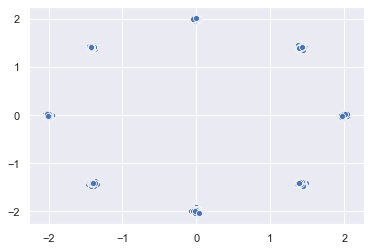

In [3]:
sns.set()
dset = gauss_circle()
data = dset.sample(1000)
_ = sns.scatterplot(data[:, 0], data[:, 1])

Center assignment std: 0.08031889803653476


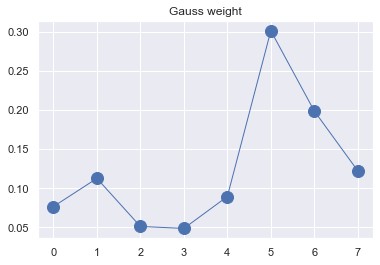

In [4]:
sns.set()
plt.plot(dset.p, 'bo-', linewidth=1, markersize=12)
plt.title('Gauss weight')
print("Center assignment std: {}".format(np.std(dset.p)))

In [5]:
# Hyper parameters of model from https://arxiv.org/abs/1611.02163
# "unrolled gan"
latent_dim = 256
generator_hidden = 128
discriminator_hidden = 128

gen_input = latent_dim
gen_output = dset.size
dis_input = dset.size

lr_dis = 1e-4
lr_gen = 1e-4
betas = (0.5, 0.999)
use_cuda = False

In [ ]:
# Variant on D. Ulyanov, A. Vedaldi, and V. Lempitsky. Adversarial generator-encoder networks. arXiv
# preprint arXiv:1704.02304, 2017.

In [16]:
# Network definitions
def sample_gauss_noise(batch_size, dim):
    return torch.Tensor(batch_size, dim).normal_(0, 1)

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.map1(x))
        x = torch.relu(self.map2(x))
        return torch.tanh(self.map3(x))

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.tanh(self.map1(x))
        x = torch.tanh(self.map2(x))
        return self.map3(x)

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.map1(x))
        x = torch.relu(self.map2(x))
        return torch.sigmoid(self.map3(x))

In [19]:
# Standard loop from DCGAN training
def train_validate(E, G, D, E_optim, G_optim, D_optim, dset, num_iter):
    
    generated_samples = []
    batch_size = 512
    for i in range(num_iter):


        x = torch.from_numpy(dset.sample(batch_size))
        x = x.cuda() if use_cuda else x

        # Real data, discriminator forward
        y_real = D(x)

        # Sample z from uniform
        z = sample_gauss_noise(batch_size, latent_dim).type(dtype)

        # Generator forward
        with torch.no_grad():
            x_fake = G(z).detach()
        y_fake = D(x_fake)

        # Discriminator loss
        y_ones = torch.ones(batch_size, )
        y_zeros = torch.zeros(batch_size, )

        y_ones = y_ones.cuda() if use_cuda else y_ones
        y_zeros = y_zeros.cuda() if use_cuda else y_zeros

        d_loss = loss_bce(y_real, y_ones) + loss_bce(y_fake, y_zeros)

        D_optim.zero_grad()
        d_loss.backward()
        D_optim.step()

        # Generator forward again
        z = sample_gauss_noise(batch_size, latent_dim).type(dtype)

        # Generator forward
        x_fake = G(z)
        y_fake = D(x_fake)

        # Generator loss
        y_ones = torch.ones(batch_size, )
        y_ones = y_ones.cuda() if use_cuda else y_ones

        g_bce_loss = loss_bce(y_fake, y_ones)
        
        z_hat = E(x)
        
        x_hat = G(z_hat)
        
        g_mse_loss = loss_mse(x_hat.view(-1, 1), x.view(-1, 1))
        
        g_loss = g_bce_loss + g_mse_loss
        
        e_loss = loss_mse(z_hat.view(-1, 1), z.view(-1, 1))
        
        E_optim.zero_grad()
        e_loss.backward(retain_graph=True)
        E_optim.step()
        # back
        # optim
        
        G_optim.zero_grad()
        g_loss.backward(retain_graph=True)
        G_optim.step()
        
        # Generate examples
        if i % 1000 == 0:
            # Generator forward
            z = sample_gauss_noise(batch_size, latent_dim).type(dtype)
            with torch.no_grad():
                x_fake = G(z).cpu().detach().numpy()
            
            generated_samples.append(x_fake)
            
            plt.scatter(x_fake[:, 0], x_fake[:, 1], s=10, c='b', alpha=0.5)
            plt.scatter(dset.centers[:, 0], dset.centers[:, 1], s=100, c='g', alpha=0.5)
            
            plt.ylim(-5, 5)
            plt.xlim(-5, 5)
            plt.show()
            plt.close()
            
            
            
            
    # visualize all samples
    xmax = 5
    cols = len(generated_samples)
    bg_color  = sns.color_palette('Greens', n_colors=256)[0]
    plt.figure(figsize=(2*cols, 2))
    for i, sample in enumerate(generated_samples):
        if i == 0:
            ax = plt.subplot(1, cols, 1)
        else:
            plt.subplot(1, cols, i+1, sharex=ax, sharey=ax)
        ax2 = sns.kdeplot(sample[:, 0], sample[:, 1], shaded=True, cmap='Greens', n_levels=20, clip=[[-xmax, xmax]]*2)
        plt.xticks([])
        plt.yticks([])
        plt.title('step %d'%(i*1000))

    plt.gcf().tight_layout()
    plt.show()
    plt.close()
        
    return 
#     return G_batch_loss / num_iter, D_batch_loss / num_iter

/Users/Maurits/Development/virtual_env/ML/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


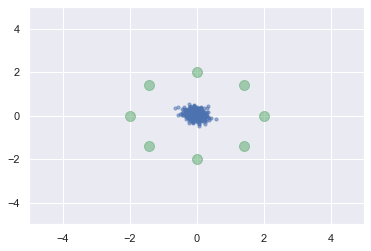

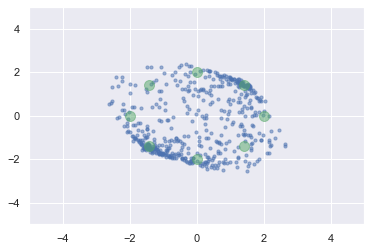

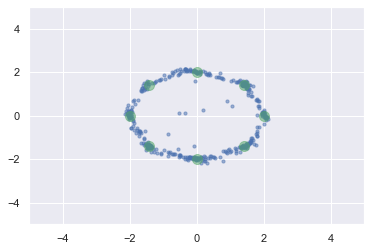

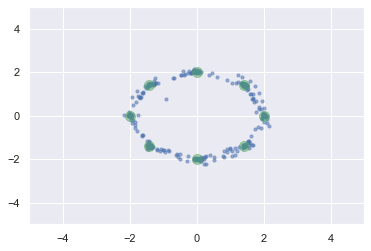

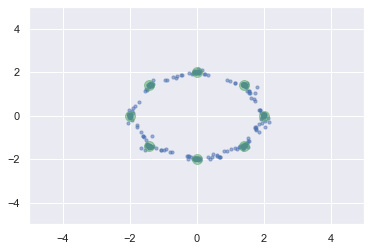

/Users/Maurits/Development/virtual_env/ML/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'shaded'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


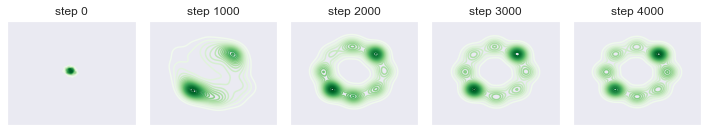

In [20]:
# Enable CUDA, set tensor type and device
if use_cuda:
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda:0")
    print('GPU')
else:
    dtype = torch.FloatTensor
    device = torch.device("cpu")


E = Encoder(2, generator_hidden, latent_dim)
G = Generator(latent_dim, generator_hidden, gen_output)
D = Discriminator(dis_input, discriminator_hidden, 1)

if use_cuda:
    G = G.cuda()
    D = D.cuda()
    E = E.cuda()
    
# Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
loss_bce = nn.BCELoss()
loss_mse = nn.MSELoss()

E_optim = optim.Adam(E.parameters(), lr=lr_dis, betas=betas)
D_optim = optim.Adam(D.parameters(), lr=lr_dis, betas=betas)
G_optim = optim.Adam(G.parameters(), lr=lr_gen, betas=betas)



num_iter = 5000
train_validate(E, G, D, E_optim, G_optim, D_optim, dset, num_iter)